In [269]:
import os
import re
import sys
import string
import itertools
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

from app.backend.utils import DbEngine, Queries
from app.backend.etl import ETL
from app.backend.etl_sdhi import ETL_SDHI
from app.encoding_module.encoder import Encoding

In [363]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score, fowlkes_mallows_score, silhouette_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, TimeSeriesSplit, StratifiedKFold, cross_validate

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import lightgbm as lgb

from kmodes.kmodes import KModes
from scipy.spatial import distance
from scipy import stats
from scipy.stats import uniform, randint

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

In [220]:
pd.set_option("display.max_columns", 100)

### Connect to DB

In [4]:
db_engine = DbEngine(user = 'team77', 
                     password = 'mintic2020.',
                     ip = '172.17.0.3', 
                     port = '5432', 
                     db = 'minjusticia')
engine = db_engine.connect()
queries = Queries(engine)

### Loading original data

In [5]:
data = pd.read_excel('data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)
data_shdi = pd.read_excel('data/SHDI Colombia 4.0.xlsx')

In [6]:
data2 = data[['INTERNOEN', 'DELITO', 'TITULO_DELITO', 'SUBTITULO_DELITO', 'TENTATIVA',
       'AGRAVADO', 'CALIFICADO', 'FECHA_INGRESO', 'FECHA_SALIDA',
       'FECHA_CAPTURA', 'SITUACION_JURIDICA', 'ANO_NACIMIENTO', 'EDAD',
       'GENERO', 'ESTADO_CIVIL', 'PAIS_INTERNO', 'DEPARTAMENTO', 'CIUDAD',
       'REINCIDENTE', 'ESTADO_INGRESO', 'ACTIVIDADES_TRABAJO',
       'ACTIVIDADES_ESTUDIO', 'ACTIVIDADES_ENSEÑANZA', 'NIVEL_EDUCATIVO',
       'HIJOS_MENORES', 'CONDIC_EXPECIONAL', 'CODIGO_ESTABLECIMIENTO',
       'ESTABLECIMIENTO', 'DEPTO_ESTABLECIMIENTO', 'MPIO_ESTABLECIMIENTO',
       'REGIONAL', 'ESTADO']]

### Execute ETL

In [ ]:
etl = ETL(queries)
etl.inmate_static_info(data2)
etl.inmate_variable_info(data2)

In [ ]:
etl_sdhi = ETL_SDHI(queries)
etl_sdhi.inmate_static_info(data_shdi)

### Functions

#### encodings

In [7]:
def encode_transform(data):
    encoders = []
    encoded_cols = []
    for i in range(data.values.shape[1]):
        le = LabelEncoder()
        le.fit(data.values[:,i])
        encoders.append(le)
        encoded_cols.append(le.transform(data.values[:,i]).reshape(-1,1))
    return np.concatenate(encoded_cols, axis = 1), encoders

#### metrics-results

In [8]:
def plot_confusion_matrix(labels, prediction, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.get_cmap('Blues')):
    """ Dibuja la matriz de confusion de los resultados de clasificacion de un modelo.
    Se puede aplicar normalizacion ajustando 'normalize=True'. """

    n = len(classes)
    if len(prediction.shape) != 1:
        matrix = multilabel_confusion_matrix(labels, prediction).reshape(n,4)
    else:
        matrix = confusion_matrix(labels, prediction)

    size = 1.4 * len(classes)
    plt.figure(figsize=(size, size))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))

    if len(prediction.shape) != 1:
        plt.xticks(tick_marks, ['True Negatives', 'False Negatives', 'False Positives', 'True Positives'], rotation=90)
    else:
        plt.xticks(tick_marks, classes, rotation=90)

    plt.yticks(tick_marks, classes)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment='center',
                 color='white' if matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def classifier_results(prediction, labels, classes, show_plots):
    """ Muestra los resultados de accuracy, presenta los resultados de precision, recall y f1-score
    y genera la matriz de confusion para el conjunto de datos."""

    print('\nAccuracy:\n{0:.2f}'.format(accuracy_score(labels, prediction)))

    print(classification_report(labels, prediction, digits=2, target_names = classes))
    
    if show_plots:
        plot_confusion_matrix(labels, prediction, classes)

    return classification_report(labels, prediction, digits=2, output_dict=True)

def plot_roc(y_test, y_preds):
    """
    Helper function that plots the roc curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = roc_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ROC')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall(y_test, y_preds):
    #plt.figure(figsize=(8,8))
    #for idx, label in enumerate(classes):
    #    roc_auc = auc(x[idx], y[idx])
    #    plt.plot(x[idx], y[idx], linewidth=2, label=str(label) + ': ' + 'AUC = ' + '{0:.2f}'.format(roc_auc) + ' - ' +
    #                                                               'AP = ' + '{0:.2f}'.format(ap[idx]) + ' - ' +
    #                                                               'F1 = ' + '{0:.2f}'.format(f1[idx]))
    #plt.xlim([0.0, 1.05])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    #plt.title('Precision Recall Curve')
    #plt.legend(loc="lower right")
    #plt.grid()
    #plt.show()
    """
    Helper function that plots the roc precision recall Curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = precision_recall_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

#### algorithms

In [9]:
##### Get closest centroid unoptimized (Prediction Strength)
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

##### Get closest centroid optimized v1 (Prediction Strength)
def get_closest_centroid_optim(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance)
    
    return centroids[idx_min_distance]

##### Get closest centroid optimized v2 (Prediction Strength)
def get_closest_centroid_optim_vectorized(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance, axis = 0)
    
    return centroids[idx_min_distance]

##### Get prediction strength unoptimized (Prediction Strength)
def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

##### Get prediction strength optimized (Prediction Strength)
def get_prediction_strength_optim(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    closest_cent = get_closest_centroid_optim_vectorized(x_test, train_centroids)
    
    co_membership = np.zeros((len(closest_cent), len(closest_cent)))
    for i in range(1, len(closest_cent)):
        diag = (closest_cent == np.roll(closest_cent, shift = i, axis = 0)).all(1)[i:]
        co_membership[range(i,len(closest_cent)),range(len(diag))] = diag
    co_membership = co_membership + co_membership.T - np.diag(np.diag(co_membership))
    
    # calculate the prediction strengths for each cluster
    n_test = len(x_test)
    ss = []
    for j in range(k):
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
        for i in range(len(test_labels)):
            diag = (test_labels == np.roll(test_labels, shift = i)) & (test_labels == j)
            diag = diag[i:]
            test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
        test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))
        s = (co_membership * test_labels_co_mem).sum()
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

### Encode

In [10]:
encoding = Encoding(queries)

In [12]:
inmate_sup = encoding.get_data('recidivism')

In [13]:
data_encoded = encoding.supervised(inmate_sup)

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [18]:
data_encoded.shape

(103216, 237)

In [15]:
data_encoded.columns

Index(['INTERNOEN', 'FECHA_INGRESO', 'FECHA_SALIDA', 'ANIO_NACIMIENTO',
       'GENERO', 'HIJOS_MENORES', 'ACTIVIDADES_TRABAJO', 'ACTIVIDADES_ESTUDIO',
       'ACTIVIDADES_ENSEÑANZA', 'MADRE_GESTANTE',
       ...
       'REGIONALNME_CENTRAL', 'REGIONALNME_NOROESTE', 'REGIONALNME_NORTE',
       'REGIONALNME_OCCIDENTE', 'REGIONALNME_ORIENTE',
       'REGIONALNME_VIEJO CALDAS', 'timejail_day', 'FECHA_SALIDA_t_1',
       'recidivism_day', 'year'],
      dtype='object', length=237)

#### Evaluating remaining Nans

Im gonna delete the out dates

In [17]:
data_encoded.isnull().sum().to_frame().rename(columns={0:'counts'}).sort_values(by='counts', ascending = False)

,counts
FECHA_SALIDA_t_1,78809
FECHA_SALIDA,30291
INTERNOEN,0
JAILNAME_EPMSC LA PLATA,0
JAILNAME_EPMSC FACATATIVA,0
...,...
JAILNAME_COMPLEJO IBAGUE - PICALEÑA,0
JAILNAME_CPAMS LA PAZ,0
JAILNAME_CPAMS PALMIRA,0
JAILNAME_CPMS BUCARAMANGA (ERE),0


In [21]:
data_encoded = data_encoded[data_encoded.columns[~data_encoded.columns \
                                                 .isin(['FECHA_SALIDA_t_1','FECHA_SALIDA'])]]
data_encoded.shape

(103216, 235)

#### Deleting not importante features for the analysis

In [30]:
identity = data_encoded[['INTERNOEN','FECHA_INGRESO']]

In [31]:
data_encoded = data_encoded[data_encoded.columns[~data_encoded.columns \
                                                 .isin(['INTERNOEN',
                                                        'FECHA_INGRESO',
                                                        'FECHA_CAPTURA'])]]
data_encoded.shape

(103216, 233)

### Dimentionality Reduction

Im doing the dimentionality reduction becasue we have a mix of categorical and continuous data, which wont work well with any clustering method. Doing this, im transforming the data into a new vector space with a continuous represenation per each orthogonal feature. This wont allow us to interpret as well the cluster as before, that is why i saved the idenity df before.

In [32]:
pca = PCA(n_components = 'mle', svd_solver = 'full')
pca.fit(data_encoded.values)

PCA(n_components='mle', svd_solver='full')

In [33]:
data_reduced = pca.transform(data_encoded.values)
data_reduced.shape

(103216, 223)

### Transforming features

In [96]:
pd.DataFrame(data_reduced).describe().T

,count,mean,std,min,25%,50%,75%,max
0,103216.0,-5.580847e-14,417.457384,-858.478536,-260.084802,-73.653617,143.860538,3132.438334
1,103216.0,-1.086229e-13,326.169290,-862.664316,-43.706455,-12.303562,22.519313,4428.426372
2,103216.0,1.040369e-13,10.006565,-18.907422,-7.301865,-1.975086,5.006814,57.259497
3,103216.0,-4.507792e-14,3.672195,-8.904631,-2.608884,-0.532936,2.801456,10.644335
4,103216.0,-8.054365e-14,2.675414,-7.062788,-2.228814,-0.158729,1.936516,7.893673
...,...,...,...,...,...,...,...,...
218,103216.0,-1.563424e-18,0.003147,-0.019736,-0.000045,0.000002,0.000044,1.009933
219,103216.0,-2.062825e-17,0.002732,-0.020298,-0.001157,0.000008,0.001439,0.029561
220,103216.0,1.277290e-16,0.001938,-0.013320,-0.000678,0.000189,0.001055,0.018743
221,103216.0,-1.556627e-16,0.000668,-0.003179,-0.000274,0.000051,0.000324,0.004502


Distribution of a few random sample of features 

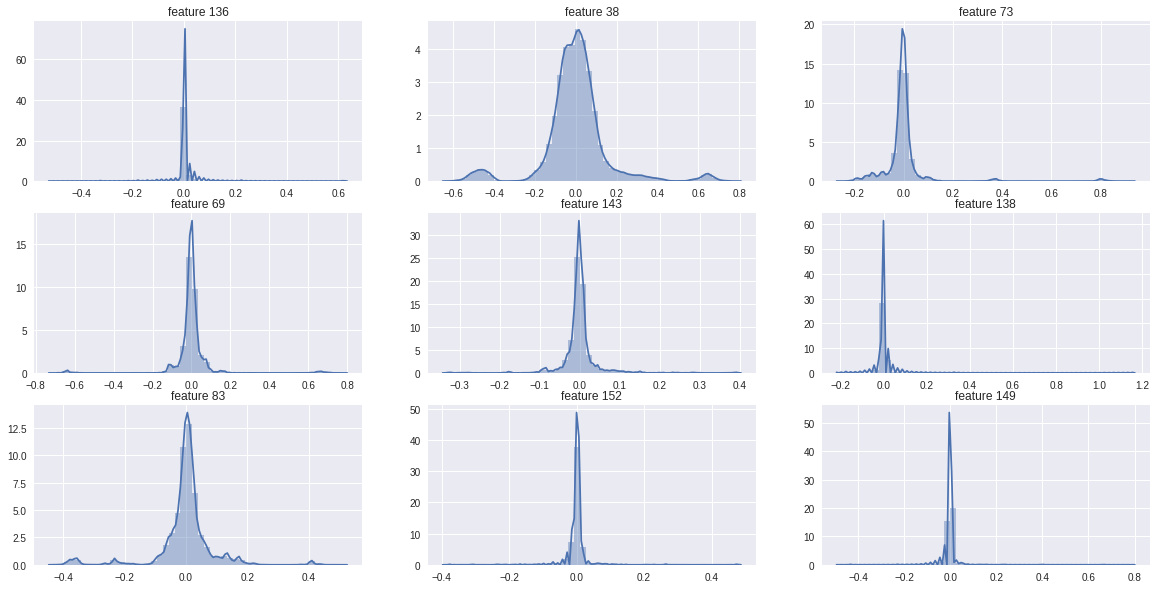

In [103]:
fig, ax = plt.subplots(figsize=(20,10))
rand_features = np.random.randint(data_reduced.shape[1], size=9)
for i, feature in enumerate(rand_features):
    plt.subplot(3,3, i + 1)
    sns.distplot(data_reduced[:,feature]).set_title('feature {}'.format(feature))

Applying a box cox transformation to each feature to make them closer to a normal distribution

In [101]:
transformed_data = []
for i in range(data_reduced.shape[1]):
    if (data_reduced[:,i] < 0).any():
        shift = np.abs(data_reduced[:,i].min()) + 1e-3
        feature_transformed, _ = stats.boxcox(data_reduced[:,i] + shift)
        transformed_data.append(feature_transformed.reshape(-1,1))

In [102]:
data_reduced_transformed = np.concatenate(transformed_data, axis = 1)
data_reduced_transformed.shape

(103216, 223)

Distribution of a few random sample of features after the boxcox transformation

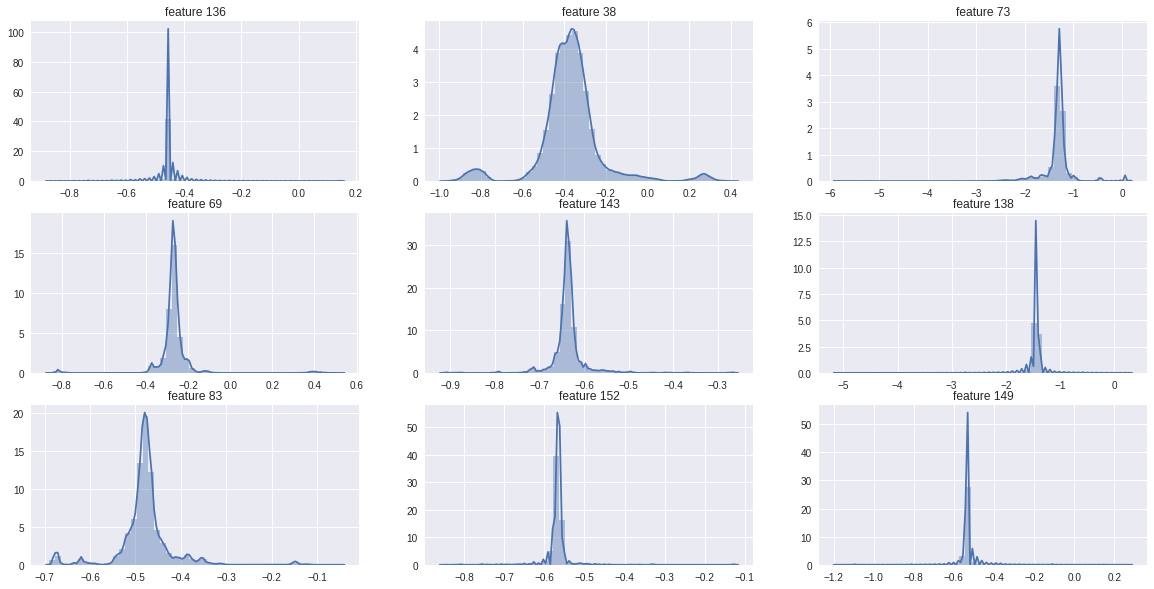

In [104]:
fig, ax = plt.subplots(figsize=(20,10))
for i, feature in enumerate(rand_features):
    plt.subplot(3,3, i + 1)
    sns.distplot(data_reduced_transformed[:,feature]).set_title('feature {}'.format(feature))

Creating a pairplot to visualize the transformation changes

In [122]:
sampled_features_1 = pd.DataFrame(data_reduced[:,rand_features], columns = rand_features)
sampled_features_1['type'] = 'not transformed'

In [123]:
sampled_features_2 = pd.DataFrame(data_reduced_transformed[:,rand_features], columns = rand_features)
sampled_features_2['type'] = 'transformed'

In [124]:
sampled_features = pd.concat([sampled_features_1, sampled_features_2], axis = 0)

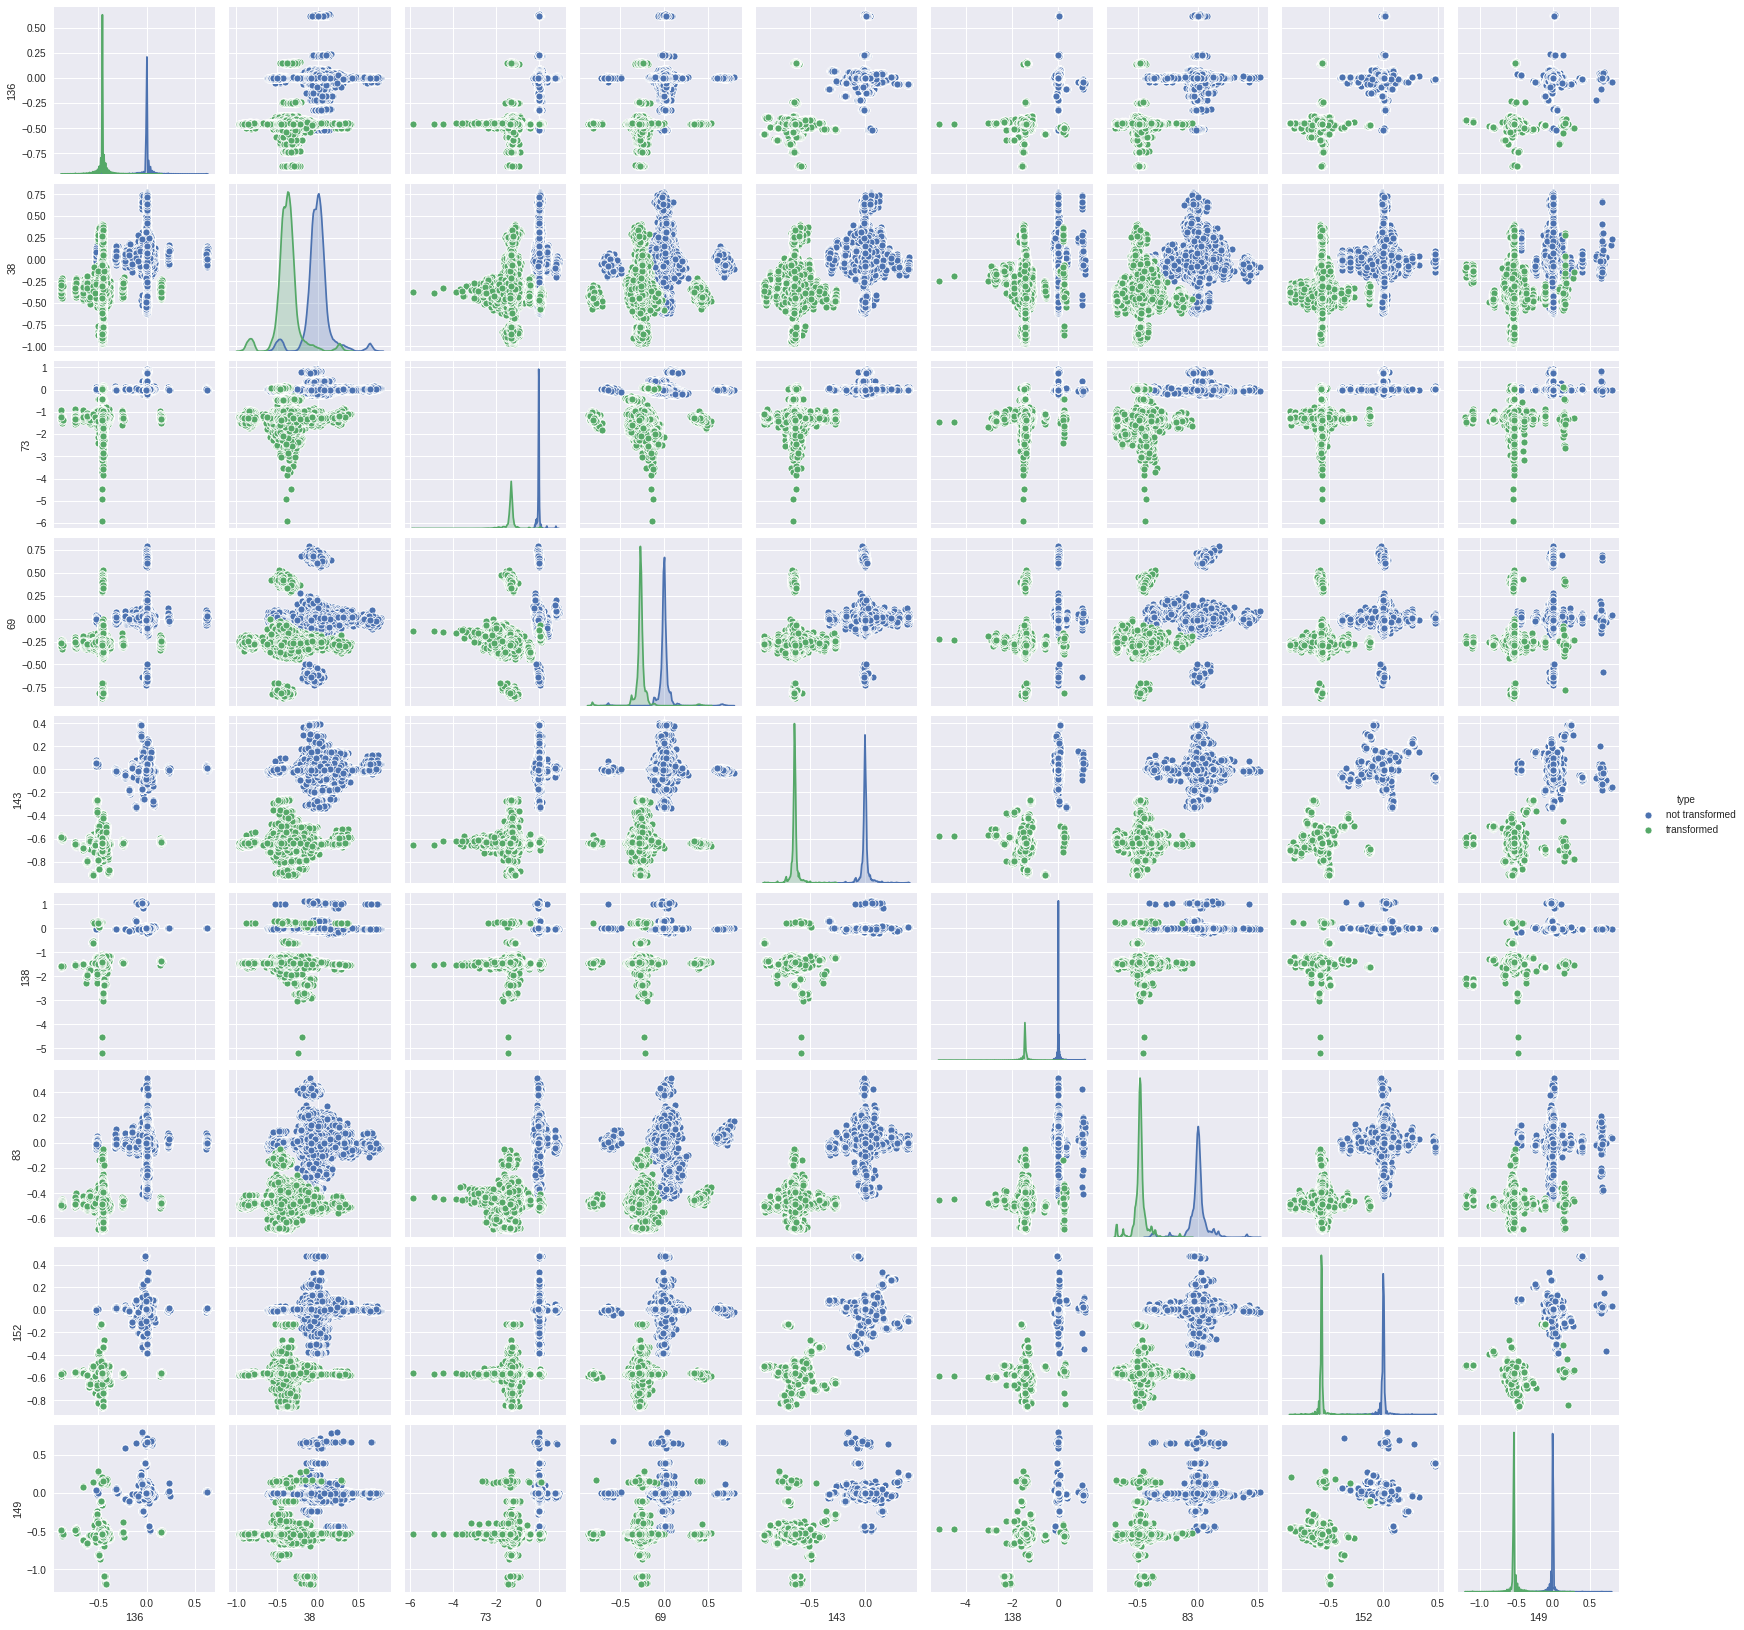

In [125]:
sns.pairplot(sampled_features, hue="type")

### Unsupervised Learning with GMM

#### PCA only transformed

In [216]:
def cluster_interation(data2learn, n_clusters):
    # setting the range of k
    clusters = range(2, n_clusters)
    # running the clustering 
    wss_list = []
    k_calinski_harabasz = []
    silhouette = []
    for k in clusters:
        #gmm = GaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
        gmm = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
        gmm.fit(data2learn)
        c_labels = gmm.predict(data2learn)

        #Within sum of squares
        wss = 0
        for k in np.unique(c_labels):
            c_idx = c_labels == k
            d_ck = data2learn[c_idx]
            center = gmm.means_[k]
            wss += ((d_ck - center)**2).sum(1).sum()
        wss_list.append(wss)

        #calinski_harabasz_score
        k_calinski_harabasz.append(calinski_harabasz_score(data2learn, c_labels))

        # silhouette_score
        silhouette.append(silhouette_score(data2learn, c_labels))
        
    return wss_list, k_calinski_harabasz, silhouette

In [218]:
number_clusters = 15
clusters = range(2, number_clusters)

In [126]:
wss_list, k_calinski_harabasz, silhouette = cluster_interation(data2learn = data_reduced, 
                                                               n_clusters = number_clusters)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


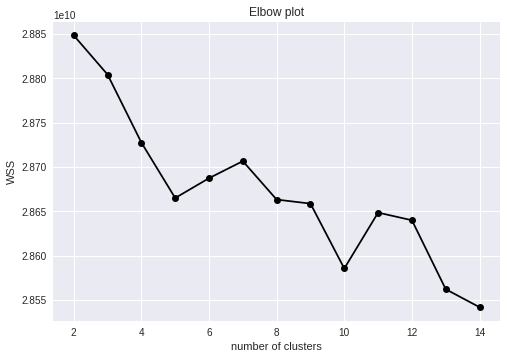

In [127]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

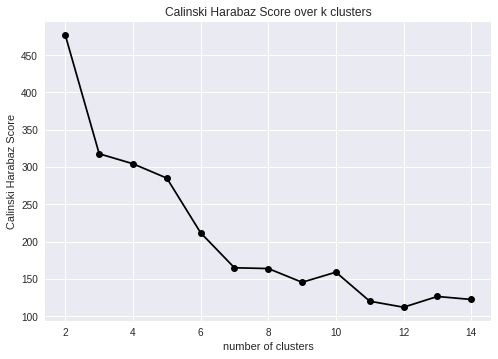

In [128]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

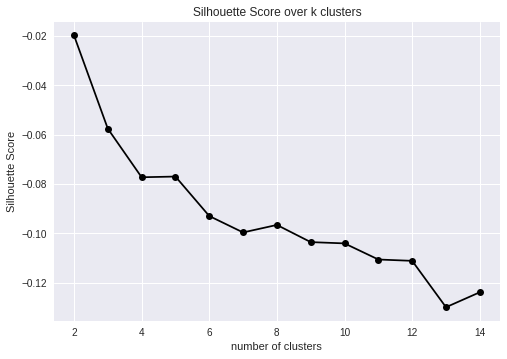

In [129]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, silhouette, '-o', color='black')
ax.set(title='Silhouette Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Silhouette Score');

#### PCA + Box Cox transformed

##### WSS, Calinski_Harabasz, Silhouette

In [217]:
number_clusters = 15
clusters = range(2, number_clusters)

In [113]:
wss_list, k_calinski_harabasz, silhouette = cluster_interation(data2learn = data_reduced_transformed, 
                                                               n_clusters = number_clusters)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


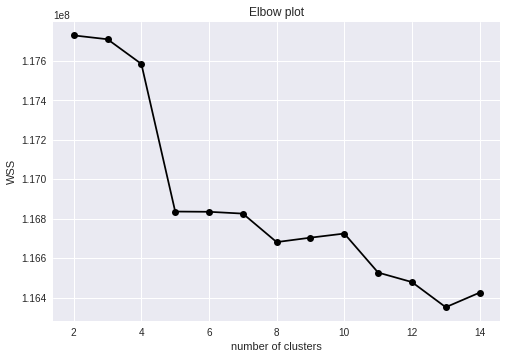

In [114]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

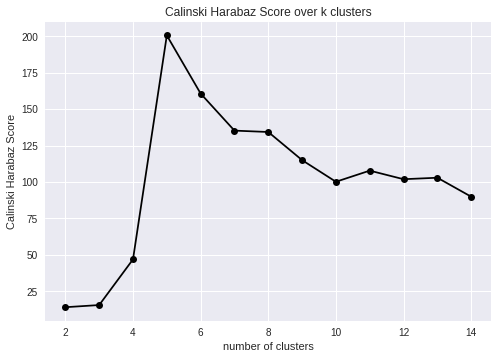

In [115]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

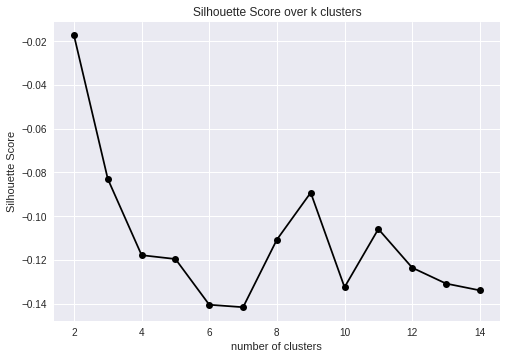

In [116]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, silhouette, '-o', color='black')
ax.set(title='Silhouette Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Silhouette Score');

##### Prediction Strength

###### Data split

In [130]:
# train/test split
X_train, X_test = train_test_split(data_reduced_transformed, 
                                   test_size=0.1, 
                                   shuffle=True, 
                                   random_state=42)

###### Running Optimized Implementation

In [131]:
# running the clustering 
strengths = []
clusters = range(2, 10)
for k in clusters:
    model_train = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42).fit(X_train)
    model_test = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.means_, X_test, model_test.predict(X_test))
    strengths.append(pred_str)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in double_scalars


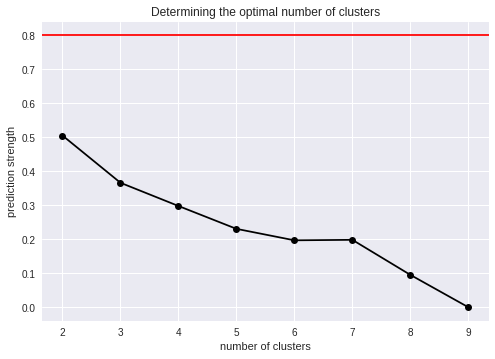

In [132]:
# plotting
### With 10% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

### Supervised Model to check feature importances

#### Training GMM optimal Number of Clusters

In [133]:
final_bgmm = BayesianGaussianMixture(n_components=5, covariance_type = 'diag', random_state=42).fit(data_reduced_transformed)
cluster_labels = final_bgmm.predict(data_reduced_transformed)

In [261]:
identity['LABEL'] = cluster_labels
identity

,INTERNOEN,FECHA_INGRESO,LABEL
0,000334541B6B3305CE91761942D7B381248777EA,2018-08-06,1
1,000357E4F19E3722BA43488F69A7D7DECFC620C4,2019-09-25,3
2,000393AD7FE65FBBE53A61B0EAA1FB9A62F71450,2013-05-17,4
3,0003BE212427DF2E9CCB2449B6012EF915B3FAE3,2014-10-24,2
4,00043EB254F6E5EFCE77A8C20BC709B63A4BE443,2018-08-23,3
...,...,...,...
103285,FFFC9F1A5227DDD6F78179576170997CAAB63AD7,2016-04-14,2
103286,FFFD204514A5DF9EE2F1E36CDBF16F0B79C45590,2015-12-24,3
103287,FFFE667F85CF452DB70B955609103CB72ECA3EEB,2020-01-14,3
103288,FFFF73D0B7088A0EF0A4B7F3CC26F8CF672C6EC1,2016-04-05,4


In [262]:
identity.to_csv('cluster_labels.csv', index = False)

#### Data Spliting

In [369]:
unique_indices = identity[['INTERNOEN','FECHA_INGRESO']]
unique_inmate = unique_indices['INTERNOEN'].unique()

In [370]:
inmate_train, inmate_test = train_test_split(unique_inmate, 
                                             test_size=0.2, 
                                             shuffle=True, 
                                             random_state=42)

In [371]:
index_train = unique_indices[unique_indices['INTERNOEN'].isin(inmate_train)].index.values
index_test = unique_indices[unique_indices['INTERNOEN'].isin(inmate_test)].index.values

In [372]:
# train/test split
X_train = data_encoded.iloc[index_train[index_train < data_encoded.shape[0]]].values
X_test = data_encoded.iloc[index_test[index_test < data_encoded.shape[0]]].values
Y_train = cluster_labels[index_train[index_train < data_encoded.shape[0]]]
Y_test = cluster_labels[index_test[index_test < data_encoded.shape[0]]]

In [373]:
pd.DataFrame(cluster_labels, columns = ['Label'])['Label'].value_counts().to_frame()

,Label
4,36692
3,34391
1,15722
2,10112
0,6299


##### Random Forest Classifier

###### Hyperparameter Search

In [359]:
clf_randomf = RandomForestClassifier(
                                     random_state=42,
                                     class_weight = 'balanced',
                                    )

In [361]:
distributions = dict(
                     n_estimators = randint(1, 2000),
                     criterion=["gini", "entropy"],
                     max_depth = randint(1, 2000),
                     min_samples_split = uniform(loc=0, scale=1),
                     min_samples_leaf = uniform(loc=0, scale=0.5),
                     max_features = uniform(loc=0, scale=1),
                    )
clf_rf_rcsv = RandomizedSearchCV(
                         clf_randomf, 
                         distributions, 
                         random_state=42, 
                         cv = StratifiedKFold(n_splits=10),
                         scoring = 'f1_weighted'
                         #scoring = ['precision','recall','roc_auc'],
                         #refit = 'precision'
                        )
rf_search = clf_rf_rcsv.fit(X_train, Y_train)

In [362]:
rf_search.best_params_

{'criterion': 'entropy',
 'max_depth': 976,
 'max_features': 0.23277134043030423,
 'min_samples_leaf': 0.0453032172664104,
 'min_samples_split': 0.6183860093330873,
 'n_estimators': 1900}

###### Model Training with Stratified Split Cross Validation

In [444]:
clf_randomf = RandomForestClassifier(
                                     random_state=42,
                                     class_weight = 'balanced',
                                     criterion ='entropy',
                                     max_depth = 976,
                                     max_features = 0.23277134043030423,
                                     min_samples_leaf = 0.0453032172664104,
                                     min_samples_split = 0.6183860093330873,
                                     n_estimators = 1900
                                    )

In [445]:
cv_results_rf = cross_validate(clf_randomf, 
                                X_train, 
                                Y_train, 
                                cv = StratifiedKFold(n_splits=10),
                                scoring = ['precision_weighted','recall_weighted','f1_weighted'],
                                return_train_score = True)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Pr

In [446]:
cv_results_rf

{'fit_time': array([131.28208041, 131.14800572, 126.9785583 , 126.89571619,
        136.25468326, 133.97194934, 133.23363709, 130.23139334,
        134.72822428, 131.18651342]),
 'score_time': array([0.98324299, 0.94199729, 0.9706521 , 0.96374488, 1.02611685,
        1.07707381, 1.01095891, 1.12649131, 1.10474825, 1.17020059]),
 'test_precision_weighted': array([0.55268305, 0.55363306, 0.53543996, 0.52945963, 0.54414601,
        0.55506873, 0.55467063, 0.55316572, 0.53888131, 0.544112  ]),
 'train_precision_weighted': array([0.54491703, 0.54824323, 0.54682804, 0.54747161, 0.54929355,
        0.54330141, 0.5481406 , 0.54548821, 0.54269806, 0.54455845]),
 'test_recall_weighted': array([0.36148812, 0.36645662, 0.35857974, 0.35155114, 0.36463888,
        0.37377288, 0.36116834, 0.37195491, 0.3583808 , 0.3679554 ]),
 'train_recall_weighted': array([0.36284556, 0.36460956, 0.36316874, 0.36394975, 0.36481155,
        0.36145373, 0.36519713, 0.36387752, 0.36316385, 0.36437574]),
 'test_f1_weig

###### Best Metrics Results

With optimal iteration per split

In [450]:
cv_results_rf_df = pd.DataFrame.from_dict(cv_results_rf).melt(var_name = 'metric', 
                                                              value_name = 'result')
cv_results_rf_df = cv_results_rf_df[~cv_results_rf_df['metric'].isin(['fit_time','score_time'])]
cv_results_rf_df['split'] = cv_results_rf_df['metric'].apply(lambda x: x.split('_')[0])
cv_results_rf_df['metric'] = cv_results_rf_df['metric'].apply(lambda x: '_'.join(x.split('_')[1:]))

In [451]:
cv_results_rf_df['metric'].unique()

array(['precision_weighted', 'recall_weighted', 'f1_weighted'],
      dtype=object)

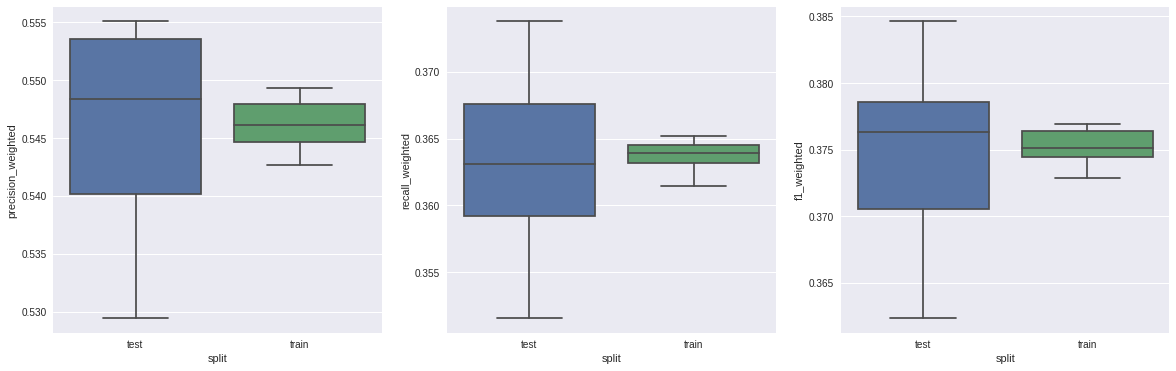

In [452]:
fig, ax = plt.subplots(figsize = (20, 6))
for i, m in enumerate(cv_results_rf_df['metric'].unique()):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = 'split', 
                     y = m, 
                     data = cv_results_rf_df[cv_results_rf_df['metric'] == m]. \
                            rename(columns = {'result': m}))

###### Model Training with tuned parameters

In [453]:
clf_randomf = RandomForestClassifier(
                                     random_state=42,
                                     class_weight = 'balanced',
                                     criterion ='entropy',
                                     max_depth = 976,
                                     max_features = 0.23277134043030423,
                                     min_samples_leaf = 0.0453032172664104,
                                     min_samples_split = 0.6183860093330873,
                                     n_estimators = 1900
                                    )
clf_randomf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=976, max_features=0.23277134043030423,
                       min_samples_leaf=0.0453032172664104,
                       min_samples_split=0.6183860093330873, n_estimators=1900,
                       random_state=42)

###### Evaluating training results


Accuracy:
0.36


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5038
           1       0.37      0.39      0.38     12591
           2       0.15      0.76      0.25      8079
           3       0.75      0.19      0.30     27451
           4       0.65      0.47      0.55     29356

    accuracy                           0.36     82515
   macro avg       0.38      0.36      0.29     82515
weighted avg       0.55      0.36      0.38     82515



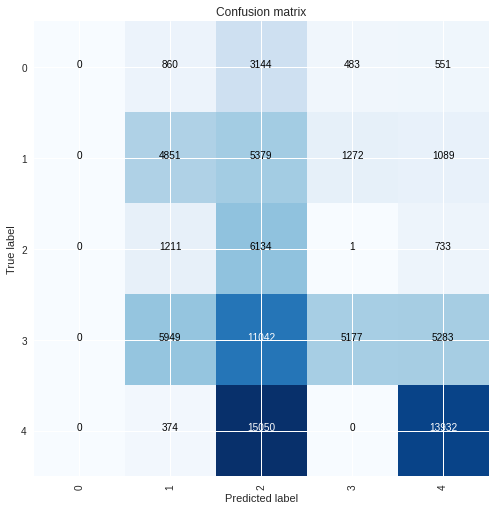

In [454]:
cr_rf_train = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_randomf.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
0.96
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1888
           1       0.98      0.97      0.97      4681
           2       0.99      1.00      0.99      3038
           3       0.98      0.93      0.95     10394
           4       0.93      1.00      0.96     10926

    accuracy                           0.96     30927
   macro avg       0.97      0.95      0.96     30927
weighted avg       0.96      0.96      0.96     30927



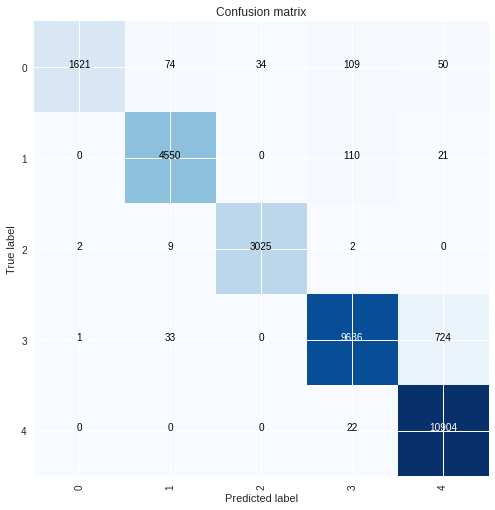

In [169]:
cr_rf_test = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_randomf.classes_], 
                           show_plots = True)

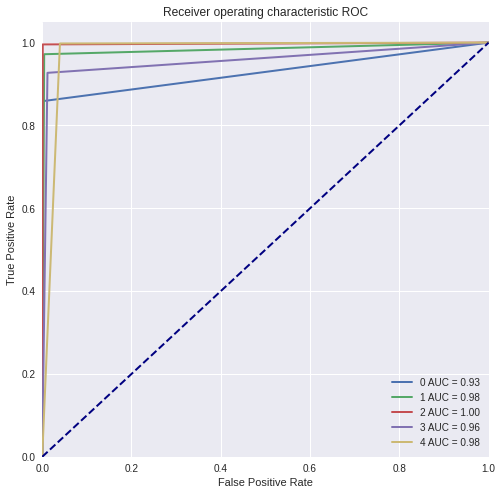

In [172]:
plot_roc(Y_test, clf_randomf.predict(X_test))

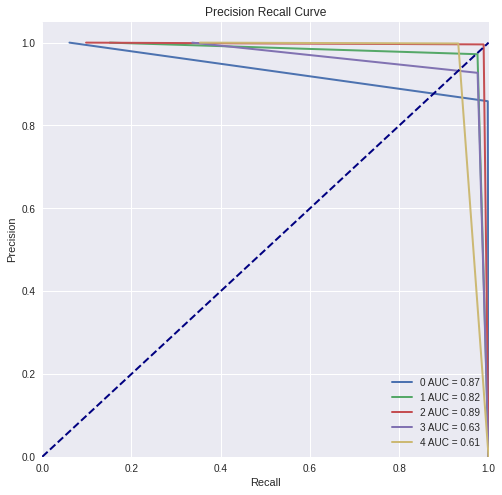

In [173]:
plot_precision_recall(Y_test, clf_randomf.predict(X_test))

###### Feature Importances

In [209]:
lg_coeffs = pd.DataFrame(clf_randomf.feature_importances_.reshape(1,-1)[:,:20], 
                         columns = data_encoded.columns[:20]) \
            .T.reset_index().rename(columns = {'index':'feature',
                                                0: 'feature_importance'}) \
            .sort_values(by=['feature_importance'], 
                         ascending = False)

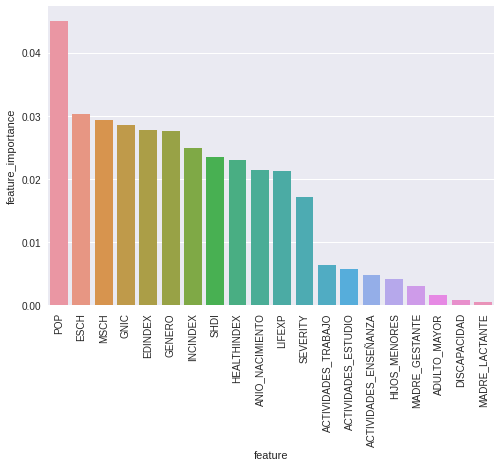

In [208]:
fig = plt.figure()
ax = sns.barplot(x='feature', y="feature_importance", data=lg_coeffs)
ax = plt.xticks(rotation=90)

##### LightGBM Classifier

###### Hyperparameter Search

In [376]:
model = lgb.LGBMClassifier(objective = "multiclassova",
                           num_class = 5,
                           metric = ["multi_error", "multi_logloss"],
                           is_unbalance = True,
                           #scale_pos_weight = sum(Y_train == 0)/sum(Y_train == 1),
                           importance_type = 'gain'
                          )

In [377]:
distributions_lgb = dict(
                     lambda_l1=uniform(loc=0, scale=50),
                     lambda_l2=uniform(loc=0, scale=50),
                     min_gain_to_split=uniform(loc=0, scale=50),
                     max_depth = randint(1, 2000),
                     n_estimators = randint(1, 2000),
                     num_iterations = randint(1, 200),
                     num_leaves = randint(1, 20000),
                     learning_rate = uniform(loc=0, scale=0.2),
                     bagging_fraction = uniform(loc=0, scale=1),
                     bagging_freq = randint(0, 10),
                     feature_fraction = uniform(loc=0, scale=1),
                     #min_data_in_leaf = randint(1, 30000)
                    )
clf_lgb = RandomizedSearchCV(
                         model, 
                         distributions_lgb, 
                         random_state=42, 
                         cv = StratifiedKFold(n_splits=10),
                         scoring = 'f1_micro'
                         #scoring = ['precision','recall','roc_auc'],
                         #refit = 'precision'
                        )
search_lgb = clf_lgb.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

In [378]:
search.best_params_

{'bagging_fraction': 0.7901755405312056,
 'bagging_freq': 4,
 'feature_fraction': 0.926300878513349,
 'lambda_l1': 32.55385127509722,
 'lambda_l2': 45.74798377718904,
 'learning_rate': 0.17000771555795988,
 'max_depth': 780,
 'min_gain_to_split': 16.54490124263246,
 'n_estimators': 1072,
 'num_iterations': 151,
 'num_leaves': 11838}

###### Model Training with Stratified Split Cross Validation

In [383]:
def cross_val_results(X, Y, n_splits, metrics_to_eval, hyper_params, iteration = None):
    models = {'model': [],
              'best_iteration': []}
    
    metrics = {}
    for met in metrics_to_eval:
        metrics[met] = {'train': [], 'val': []}

    scv = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, test_index) in enumerate(scv.split(X, Y)):

        X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
        Y_train, Y_test = Y[train_index], Y[test_index]
        #print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
        model = lgb.LGBMClassifier(objective = "multiclassova",
                                   num_class = 5,
                                   metric = metrics_to_eval,
                                   learning_rate = hyper_params['learning_rate'],
                                   feature_fraction = hyper_params['feature_fraction'],
                                   bagging_fraction = hyper_params['bagging_fraction'],
                                   bagging_freq = hyper_params['bagging_freq'],
                                   num_iterations = hyper_params['num_iterations'],
                                   num_leaves = hyper_params['num_leaves'],
                                   #min_data_in_leaf = hyper_params['min_data_in_leaf'],
                                   max_depth = hyper_params['max_depth'],
                                   n_estimators = hyper_params['n_estimators'],
                                   #scale_pos_weight = sum(Y_train == 0)/sum(Y_train == 1),
                                   is_unbalance = True,
                                   importance_type = 'gain',
                                   lambda_l1 = hyper_params['lambda_l1'],
                                   lambda_l2 = hyper_params['lambda_l2'],
                                   min_gain_to_split = hyper_params['min_gain_to_split']
                                  )
        model.fit(
                  X_train, Y_train, 
                  eval_set=[#(X_val, Y_val), 
                            (X_test, Y_test), 
                            (X_train, Y_train)],
                  feature_name = list(X.columns),
                  verbose = 0
                 )
        
        if not iteration:
            best_iteration = np.array(model.evals_result_['valid_0'][metrics_to_eval[0]]).argmin()
        else:
            best_iteration = iteration
            
        models['model'].append(model)
        models['best_iteration'].append(best_iteration)
        for m in metrics_to_eval:
            metrics[m]['train'].append(model.evals_result_['training'][m][best_iteration])
            metrics[m]['val'].append(model.evals_result_['valid_0'][m][best_iteration])
            
    return models, metrics

In [270]:
data_encoded = data_encoded.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [384]:
models, metrics = cross_val_results(data_encoded, cluster_labels, n_splits = 10, 
                                    metrics_to_eval = ["multi_error", "multi_logloss"], 
                                    hyper_params = search.best_params_)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

###### Best Iterations

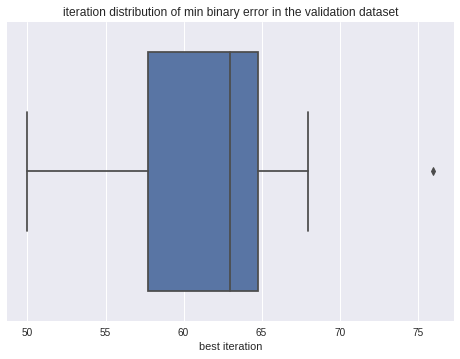

In [385]:
ax = sns.boxplot(x=models['best_iteration'])
ax.set_xlabel('best iteration')
ax = ax.set_title('iteration distribution of min binary error in the validation dataset')

In [386]:
pd.Series(models['best_iteration']).describe()

count    10.000000
mean     61.800000
std       7.612855
min      50.000000
25%      57.750000
50%      63.000000
75%      64.750000
max      76.000000
dtype: float64

###### Best Metrics Results

With optimal iteration per split

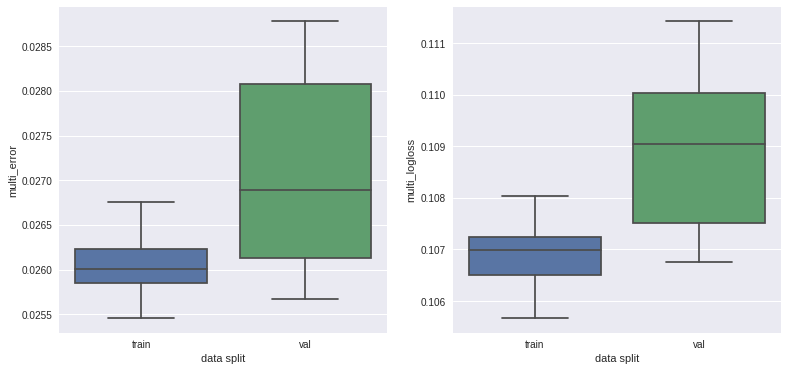

In [387]:
fig, ax = plt.subplots(figsize = (20, 6))
for i, m in enumerate(metrics.keys()):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = 'data split', 
                     y = m, 
                     data = pd.DataFrame.from_dict(metrics[m]).melt(var_name = 'data split', 
                                                                    value_name = m))

###### Model Training with Stratified Split Cross Validation (Sklearn)

In [456]:
hyper_params = search.best_params_.copy()
hyper_params

{'bagging_fraction': 0.7901755405312056,
 'bagging_freq': 4,
 'feature_fraction': 0.926300878513349,
 'lambda_l1': 32.55385127509722,
 'lambda_l2': 45.74798377718904,
 'learning_rate': 0.17000771555795988,
 'max_depth': 780,
 'min_gain_to_split': 16.54490124263246,
 'n_estimators': 1072,
 'num_iterations': 151,
 'num_leaves': 11838}

In [457]:
metrics_to_eval = ["multi_error", "multi_logloss"]

In [472]:
model_lgb = lgb.LGBMClassifier(objective = "multiclassova",
                                   num_class = 5,
                                   metric = metrics_to_eval,
                                   learning_rate = hyper_params['learning_rate'],
                                   feature_fraction = hyper_params['feature_fraction'],
                                   bagging_fraction = hyper_params['bagging_fraction'],
                                   bagging_freq = hyper_params['bagging_freq'],
                                   num_iterations = hyper_params['num_iterations'],
                                   num_leaves = hyper_params['num_leaves'],
                                   #min_data_in_leaf = hyper_params['min_data_in_leaf'],
                                   max_depth = hyper_params['max_depth'],
                                   n_estimators = hyper_params['n_estimators'],
                                   #scale_pos_weight = sum(Y_train == 0)/sum(Y_train == 1),
                                   is_unbalance = True,
                                   importance_type = 'gain',
                                   lambda_l1 = hyper_params['lambda_l1'],
                                   lambda_l2 = hyper_params['lambda_l2'],
                                   min_gain_to_split = hyper_params['min_gain_to_split']
                                  )

In [473]:
cv_results_lgb = cross_validate(model_lgb, 
                                X_train, 
                                Y_train, 
                                cv = StratifiedKFold(n_splits=10),
                                scoring = ['precision_weighted','recall_weighted','f1_weighted'],
                                return_train_score = True)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n

###### Best Metrics Results

With optimal iteration per split

In [474]:
cv_results_lgb_df = pd.DataFrame.from_dict(cv_results_lgb).melt(var_name = 'metric', 
                                                              value_name = 'result')
cv_results_lgb_df = cv_results_lgb_df[~cv_results_lgb_df['metric'].isin(['fit_time','score_time'])]
cv_results_lgb_df['split'] = cv_results_lgb_df['metric'].apply(lambda x: x.split('_')[0])
cv_results_lgb_df['metric'] = cv_results_lgb_df['metric'].apply(lambda x: '_'.join(x.split('_')[1:]))

In [475]:
cv_results_lgb_df['metric'].unique()

array(['precision_weighted', 'recall_weighted', 'f1_weighted'],
      dtype=object)

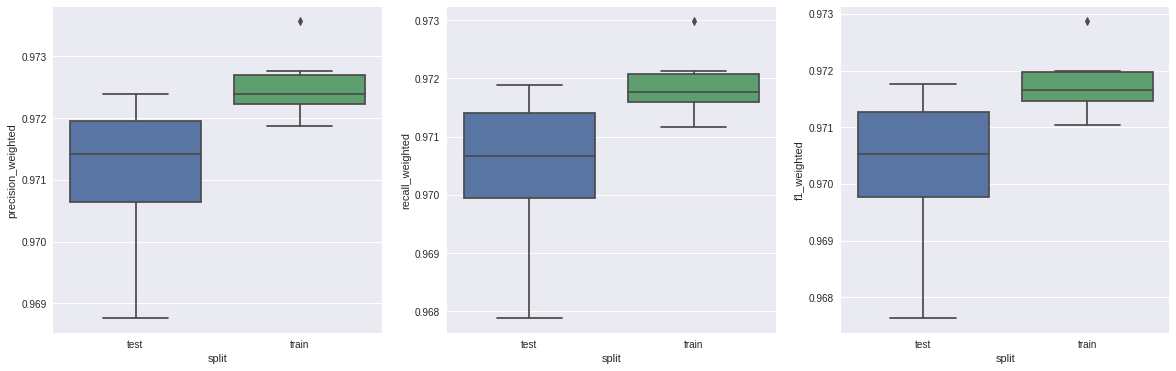

In [476]:
fig, ax = plt.subplots(figsize = (20, 6))
for i, m in enumerate(cv_results_lgb_df['metric'].unique()):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = 'split', 
                     y = m, 
                     data = cv_results_lgb_df[cv_results_lgb_df['metric'] == m]. \
                            rename(columns = {'result': m}))

###### Model Training with tuned hyperparameters

In [388]:
hyper_params = search.best_params_.copy()
hyper_params

{'bagging_fraction': 0.7901755405312056,
 'bagging_freq': 4,
 'feature_fraction': 0.926300878513349,
 'lambda_l1': 32.55385127509722,
 'lambda_l2': 45.74798377718904,
 'learning_rate': 0.17000771555795988,
 'max_depth': 780,
 'min_gain_to_split': 16.54490124263246,
 'n_estimators': 1072,
 'num_iterations': 151,
 'num_leaves': 11838}

In [392]:
metrics_to_eval = ["multi_error", "multi_logloss"]

In [393]:
model = lgb.LGBMClassifier(objective = "multiclassova",
                                   num_class = 5,
                                   metric = metrics_to_eval,
                                   learning_rate = hyper_params['learning_rate'],
                                   feature_fraction = hyper_params['feature_fraction'],
                                   bagging_fraction = hyper_params['bagging_fraction'],
                                   bagging_freq = hyper_params['bagging_freq'],
                                   num_iterations = hyper_params['num_iterations'],
                                   num_leaves = hyper_params['num_leaves'],
                                   #min_data_in_leaf = hyper_params['min_data_in_leaf'],
                                   max_depth = hyper_params['max_depth'],
                                   n_estimators = hyper_params['n_estimators'],
                                   #scale_pos_weight = sum(Y_train == 0)/sum(Y_train == 1),
                                   is_unbalance = True,
                                   importance_type = 'gain',
                                   lambda_l1 = hyper_params['lambda_l1'],
                                   lambda_l2 = hyper_params['lambda_l2'],
                                   min_gain_to_split = hyper_params['min_gain_to_split']
                                  )
model.fit(
          X_train, Y_train, 
          eval_set=[
                    (X_test, Y_test), 
                    (X_train, Y_train)],
          feature_name = list(data_encoded.columns),
          verbose = 0
         )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.7901755405312056, bagging_freq=4,
               feature_fraction=0.926300878513349, importance_type='gain',
               is_unbalance=True, lambda_l1=32.55385127509722,
               lambda_l2=45.74798377718904, learning_rate=0.17000771555795988,
               max_depth=780, metric=['multi_error', 'multi_logloss'],
               min_gain_to_split=16.54490124263246, n_estimators=1072,
               num_class=5, num_iterations=151, num_leaves=11838,
               objective='multiclassova')

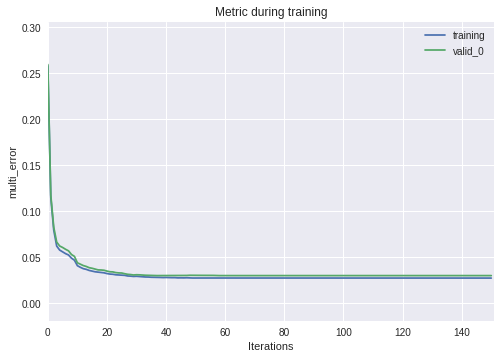

In [394]:
ax = lgb.plot_metric(model, metric = 'multi_error')

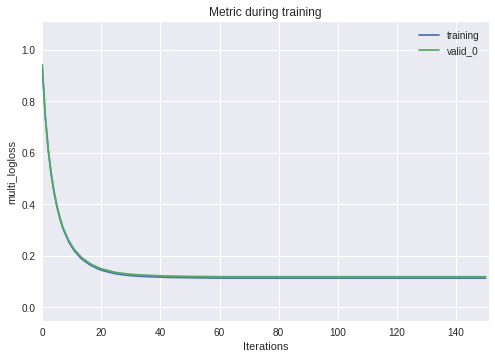

In [395]:
ax = lgb.plot_metric(model, metric = 'multi_logloss')

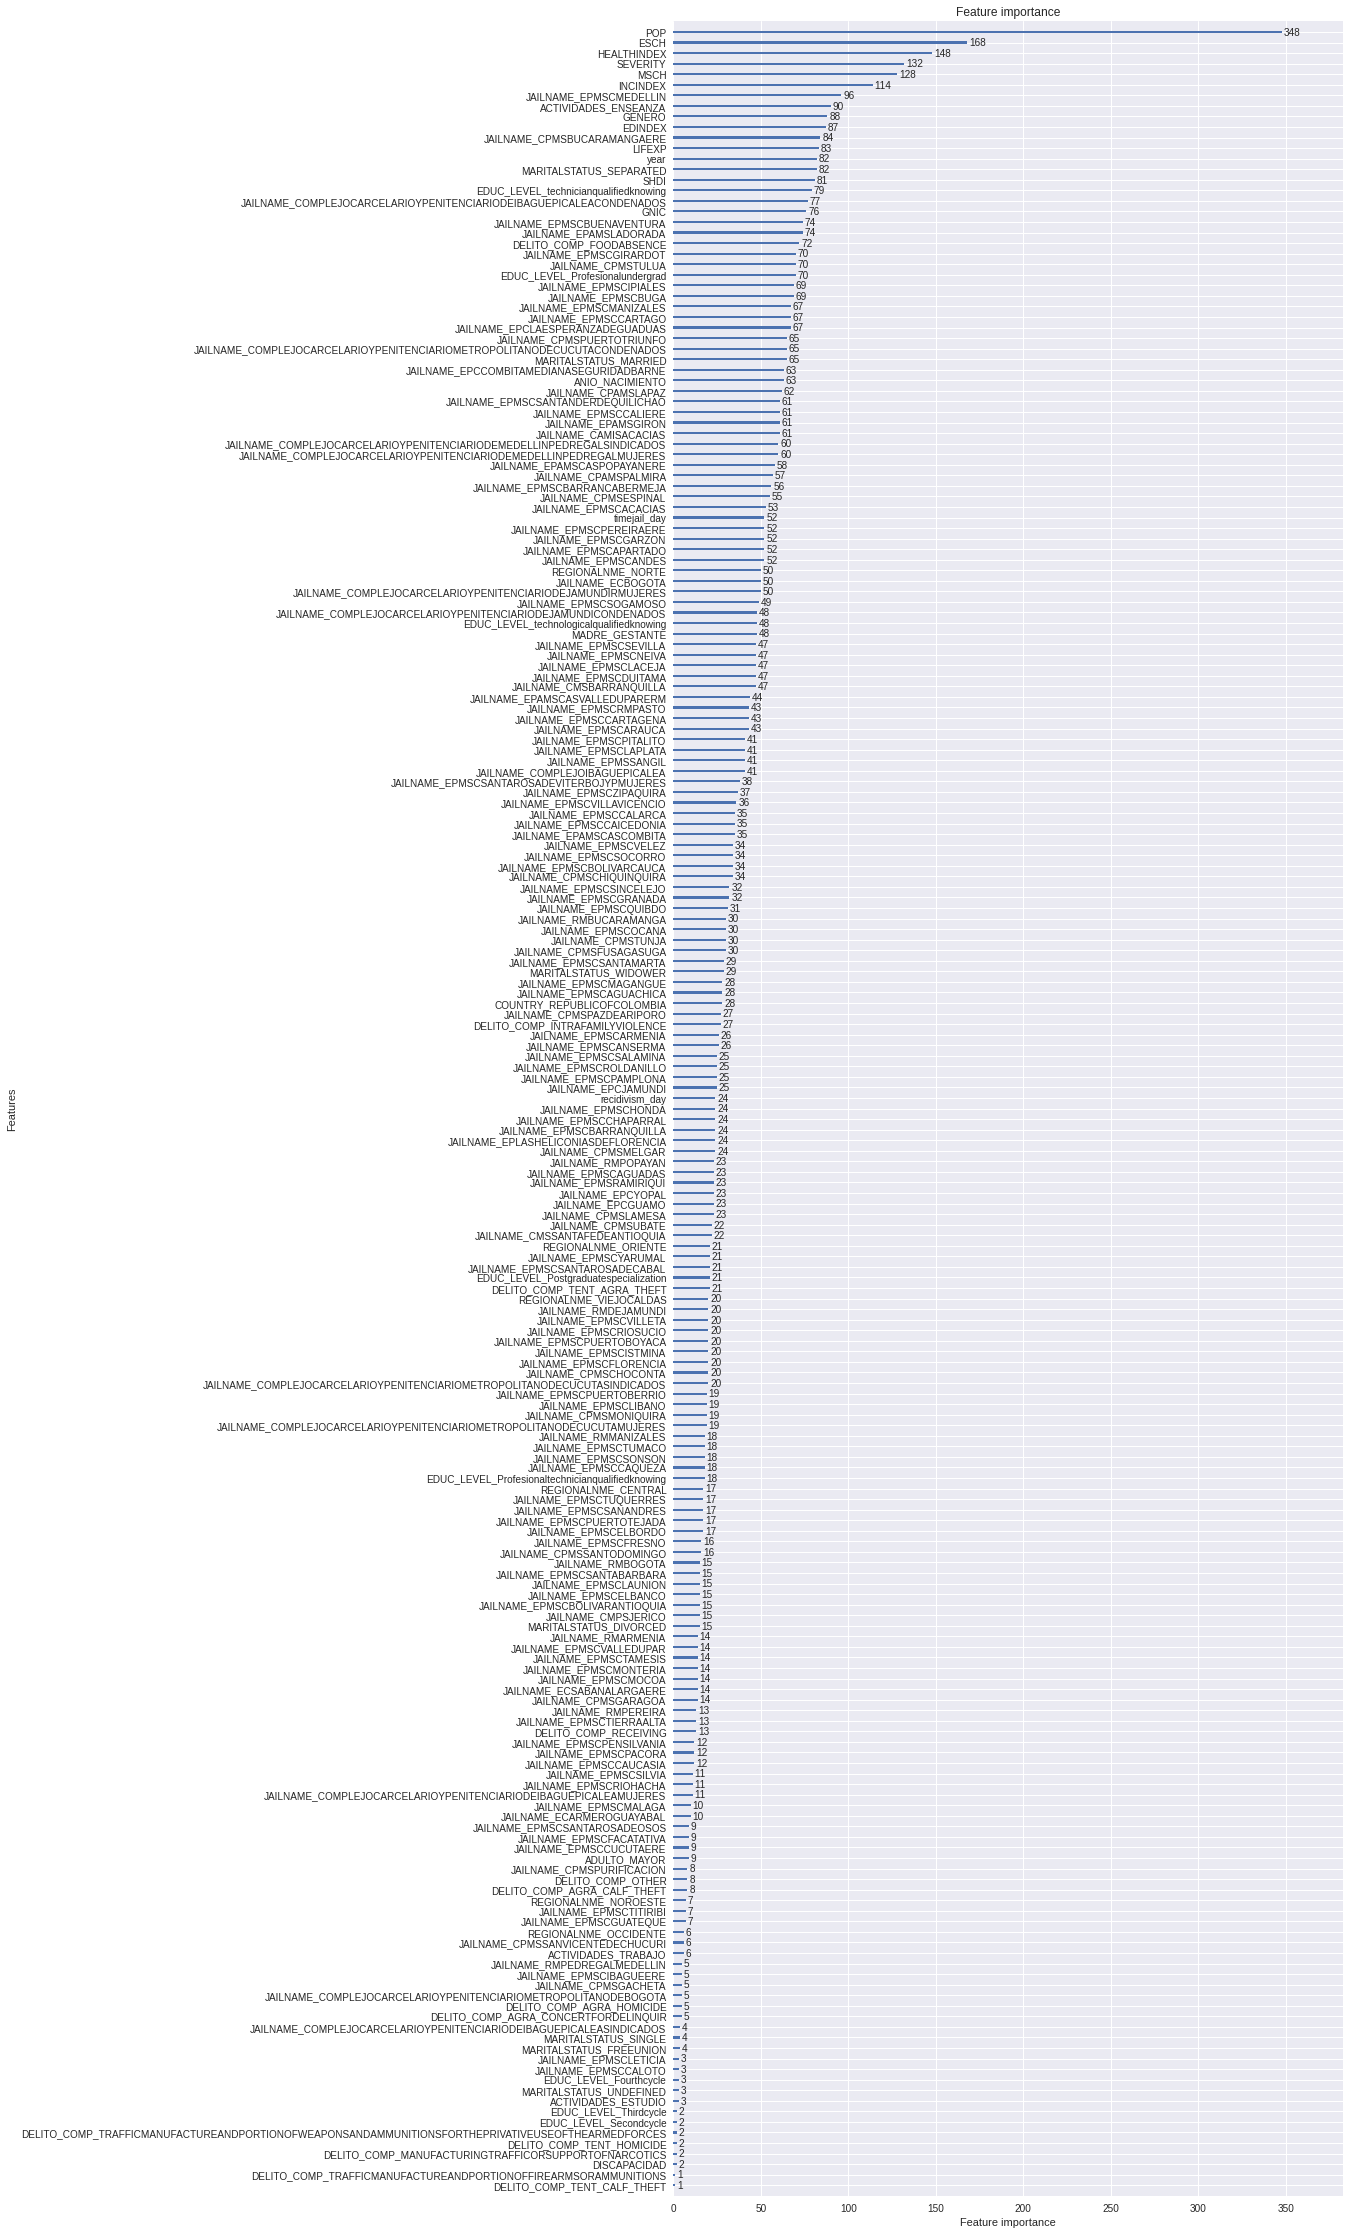

In [412]:
ax = lgb.plot_importance(model, figsize=(12,40))

In [399]:
model.booster_.save_model('lightgbm_epoch_63_multiclassova.txt', num_iteration=63)

In [405]:
model.booster_.save_model('lightgbm_epoch_20_multiclassova.txt', num_iteration=20)

###### Testing model loaded from file

In [406]:
model_loaded = lgb.Booster(model_file='lightgbm_epoch_20_multiclassova.txt')

Training Data


Accuracy:
0.97
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5038
           1       0.97      0.98      0.98     12591
           2       0.99      1.00      0.99      8079
           3       0.99      0.93      0.96     27451
           4       0.94      1.00      0.97     29356

    accuracy                           0.97     82515
   macro avg       0.97      0.96      0.97     82515
weighted avg       0.97      0.97      0.97     82515



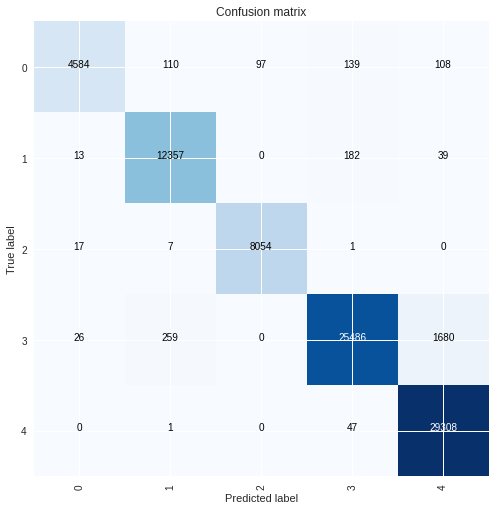

In [407]:
cr_rf_train = classifier_results(prediction = pd.DataFrame(model_loaded.predict(X_train).argmax(1))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in range(5)], 
                               show_plots = True)

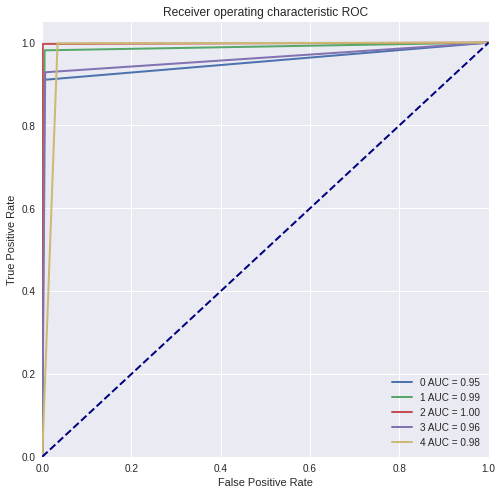

In [408]:
plot_roc(Y_train, model_loaded.predict(X_train).argmax(1))

Testing Data


Accuracy:
0.96
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1254
           1       0.97      0.98      0.98      3123
           2       0.99      1.00      0.99      2028
           3       0.99      0.92      0.95      6916
           4       0.93      1.00      0.96      7306

    accuracy                           0.96     20627
   macro avg       0.97      0.96      0.97     20627
weighted avg       0.97      0.96      0.96     20627



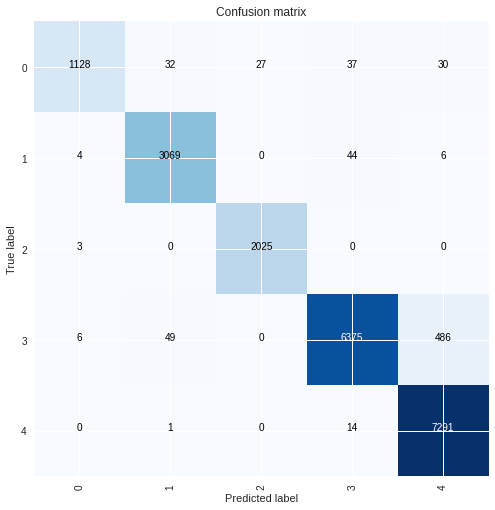

In [409]:
cr_rf_train = classifier_results(prediction = pd.DataFrame(model_loaded.predict(X_test).argmax(1))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                               classes = [str(cl) for cl in range(5)], 
                               show_plots = True)

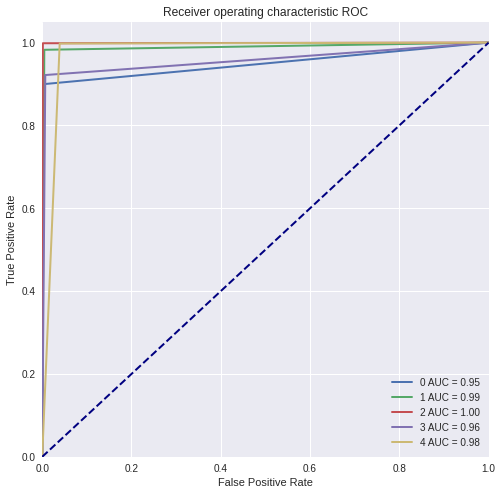

In [410]:
plot_roc(Y_test, model_loaded.predict(X_test).argmax(1))